# Coug Data Visualization

In [1]:
# imports
import rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

/home/claytonsmith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# User Variables

ROSBAGS_DIR = "~/postprocessing"
SAVES_DIR = "converted_bags"

MISSION_KEYWORDS = []
VEHCILE_NAMESPACES = ["/coug1", "/coug2", "/coug3"]
VEHICLE_IDS = [1,2]

VERBOSE=True

In [3]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/Spanish-Oaks-May-2/Bags/coug1-bag/converted__2.3_SO-2025-05-01-18-17-13
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/Spanish-Oaks-May-2/Bags/coug1-bag/converted__5.0_SO-2025-05-01-19-38-59
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/Spanish-Oaks-May-2/Bags/coug1-bag/converted__4.0_SO-2025-05-01-19-23-29
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/Spanish-Oaks-May-2/Bags/coug1-bag/converted__3.0_SO-2025-05-01-19-07-06
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/Spanish-Oaks-May-2/Bags/coug1-bag/converted__2.2_SO-2025-05-01-18-15-59
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/Spanish-Oaks-May-2/Bag

In [4]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

Spanish-Oaks-May-2/Bags/coug1-bag/converted__2.3_SO-2025-05-01-18-17-13:
	['/coug1/extended_fix', '/coug1/dvl/dr_global', '/coug1/controls/command', '/coug1/dvl/dead_reckoning', '/coug1/gps_odom', '/coug1/desired_heading', '/coug1/modem_status', '/coug1/modem_imu', '/coug1/leak/data', '/coug1/dvl/data', '/coug1/safety_status', '/coug1/controls/debug', '/coug1/fix', '/coug1/pressure/data', '/coug1/battery/data', '/coug1/depth_data', '/tf', '/coug1/dvl/position', '/coug1/kinematics/command', '/coug1/desired_speed', '/coug1/desired_depth', '/tf_static', '/coug1/dvl/velocity']
Spanish-Oaks-May-2/Bags/coug1-bag/converted__5.0_SO-2025-05-01-19-38-59:
	['/coug1/extended_fix', '/coug1/dvl/dr_global', '/coug1/controls/command', '/coug1/dvl/dead_reckoning', '/coug1/gps_odom', '/coug1/desired_heading', '/coug1/modem_status', '/coug1/modem_imu', '/coug1/leak/data', '/coug1/dvl/data', '/coug1/safety_status', '/coug1/controls/debug', '/coug1/fix', '/coug1/pressure/data', '/coug1/battery/data', '/cou

In [5]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
dfsByTopic = {}
for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
print(list(dfsByTopic.keys()))

['/coug1/extended_fix', '/coug1/dvl/dr_global', '/coug1/controls/command', '/coug1/dvl/dead_reckoning', '/coug1/gps_odom', '/coug1/desired_heading', '/coug1/modem_status', '/coug1/modem_imu', '/coug1/leak/data', '/coug1/dvl/data', '/coug1/safety_status', '/coug1/controls/debug', '/coug1/fix', '/coug1/pressure/data', '/coug1/battery/data', '/coug1/depth_data', '/tf', '/coug1/dvl/position', '/coug1/kinematics/command', '/coug1/desired_speed', '/coug1/desired_depth', '/tf_static', '/coug1/dvl/velocity', '/desired_depth', '/desired_heading', '/dvl/dead_reckoning', '/dvl/data', '/extended_fix', '/desired_speed', '/pressure/data', '/modem_status', '/fix', '/dvl/dr_global', '/leak/data', '/controls/debug', '/controls/command', '/dvl/position', '/modem_imu', '/dvl/velocity', '/kinematics/command', '/battery/data', '/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/leak/data', '/coug2/safety_status', '/coug2/depth_data', '/coug2/battery/data', '/

In [6]:
# convert ros timestamps to pandas timestamps

for path, topics in dataframes.items():
    for df in topics.values():    
        if "header.stamp.sec" in df.columns: 
            df["timestamp"] = pd.to_datetime(
                df["header.stamp.sec"] * 1_000_000_000 
                + df["header.stamp.nanosec"], unit='ns'
            )

bst_timestamps = dfsByTopic["/modem_status"]["timestamp"]
print(f"basestation timeframe:\t{bst_timestamps.min()} --- {bst_timestamps.max()}")
for ns in VEHCILE_NAMESPACES:
    timestamps = dfsByTopic[ns+'/modem_status']['timestamp']
    print(f"{ns} timeframe:\t{timestamps.min()} --- {timestamps.max()}")

basestation timeframe:	2025-04-04 21:42:06.420139976 --- 2025-04-04 21:48:59.538499170
/coug1 timeframe:	2025-04-18 21:04:06.987307521 --- 2025-04-18 21:09:38.893311163
/coug2 timeframe:	2025-04-04 21:26:07.124787521 --- 2025-04-04 21:28:35.788148893
/coug3 timeframe:	2025-04-04 19:19:52.143971554 --- 2025-04-04 19:25:26.061516513


SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__SO_multi_1.0


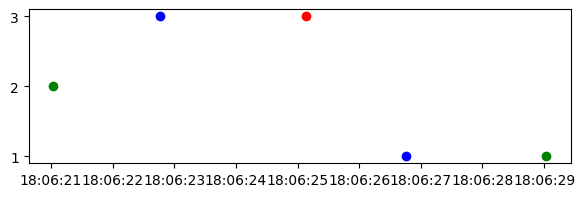

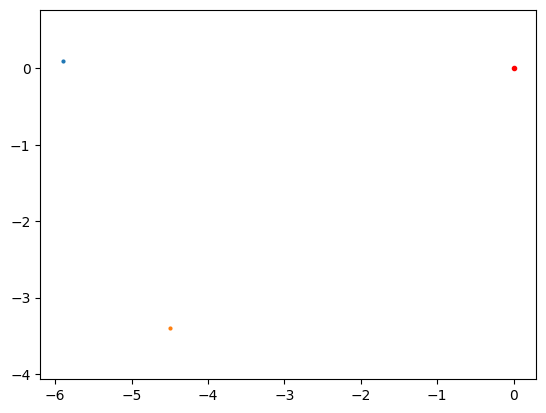

SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__SO_coug1_1.1


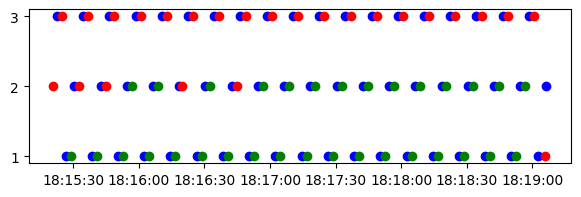

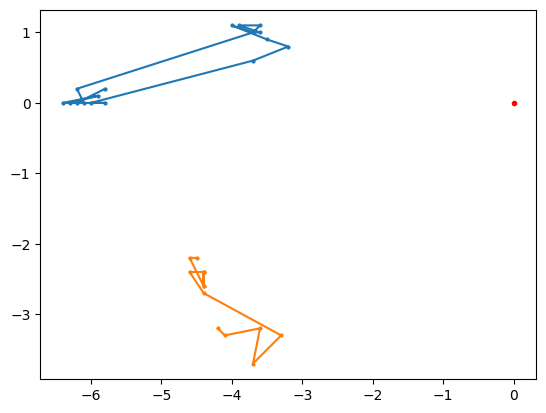

SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__SO_multia_agent_1.2


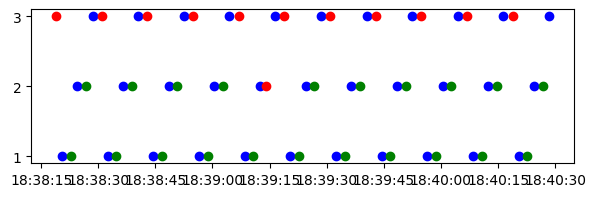

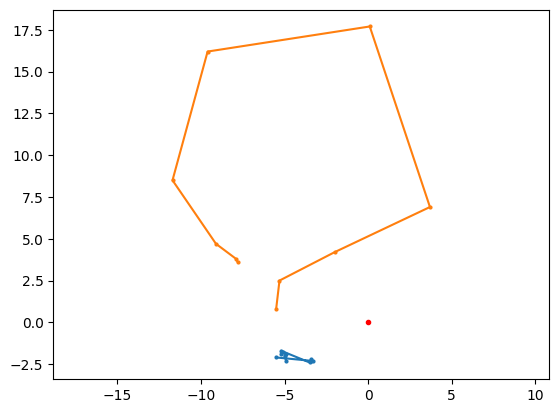

SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__SO_coug1_1.2


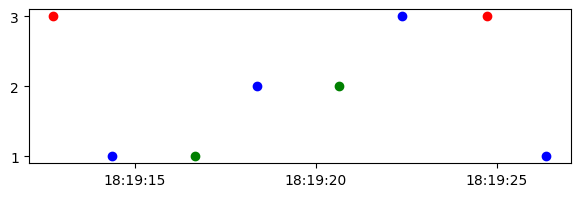

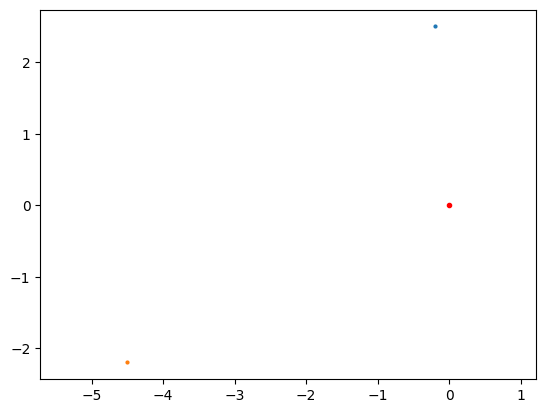

SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__SO_multia_agent_1.1


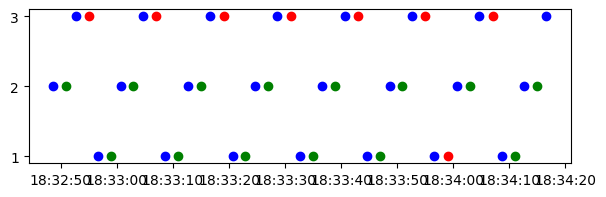

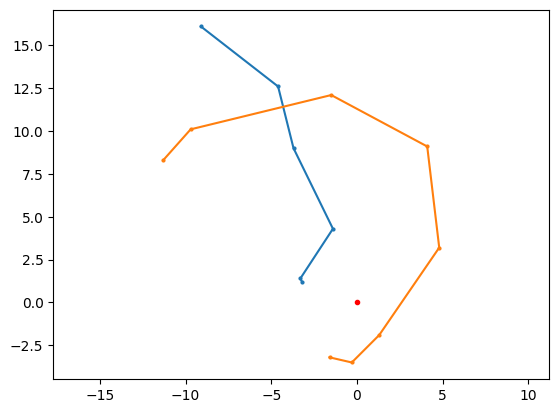

SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__SO_multi_1.1


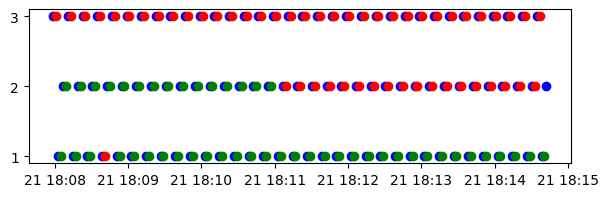

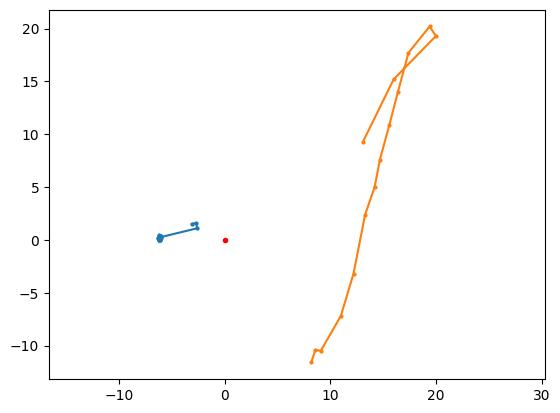

SpanishOaks-March-21-2025/bags/Base-station-bags/bags/converted__MA_BASE_X.1


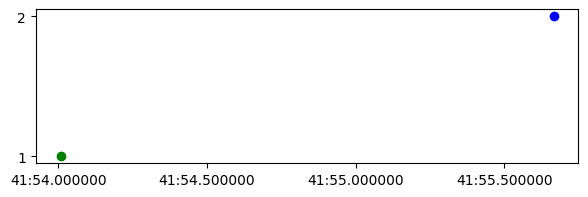

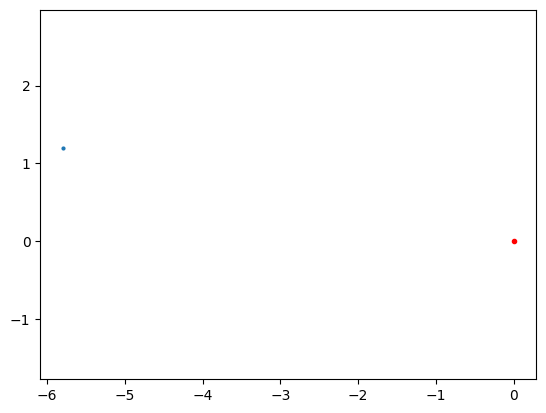

Spanish Oaks - Apr 18/bags/base_station/converted__SO_4.0_multi_base_station


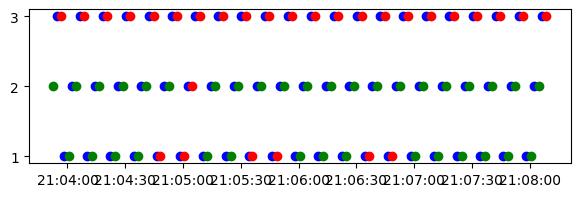

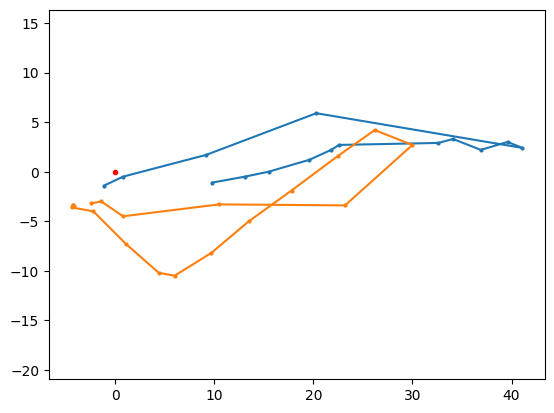

Spanish Oaks - Apr 18/bags/base_station/converted__SO_5.2_multi


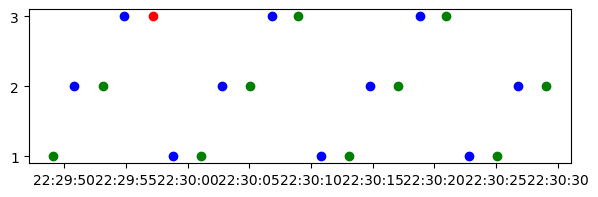

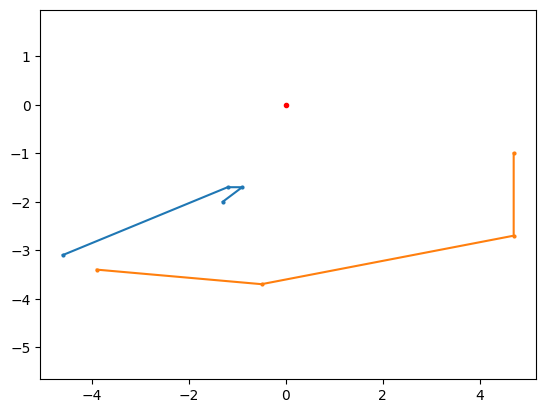

Spanish Oaks - Apr 18/bags/base_station/converted__SO_5.4_multi


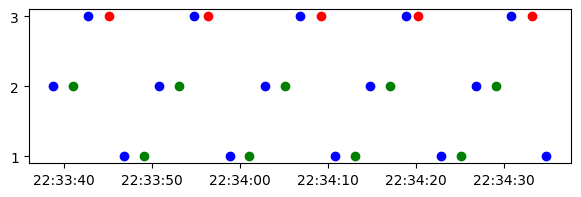

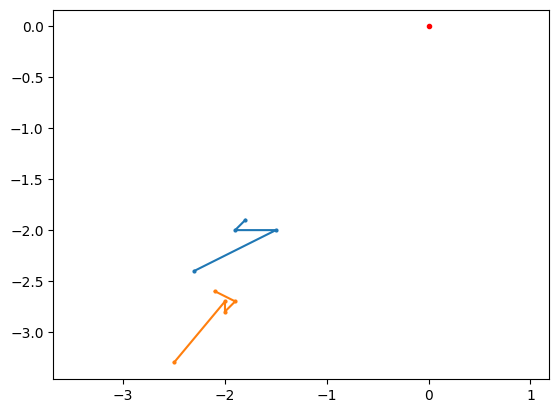

Spanish Oaks - Apr 18/bags/base_station/converted__SO_2.0_base_station


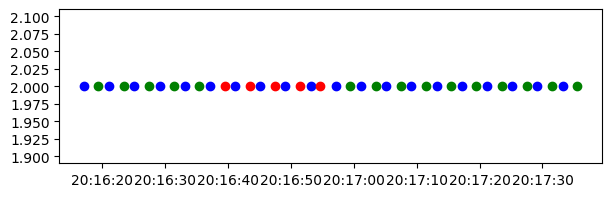

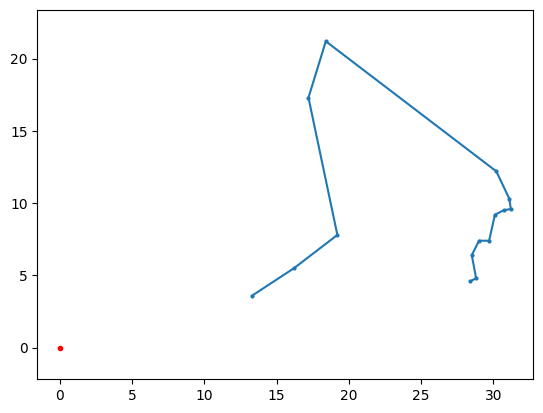

Spanish Oaks - Apr 18/bags/base_station/converted__SO_multi_3.0


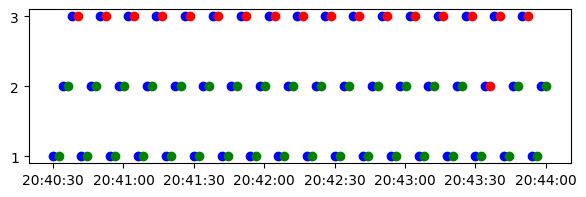

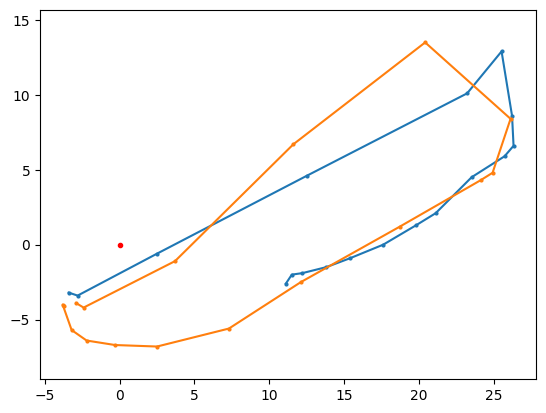

Spanish Oaks - Apr 18/bags/base_station/converted__SO_5.5_multi


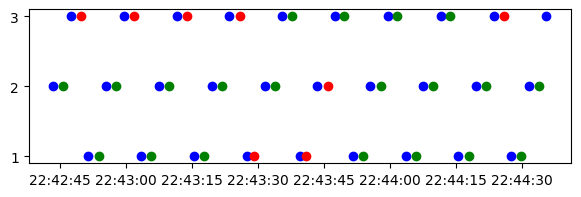

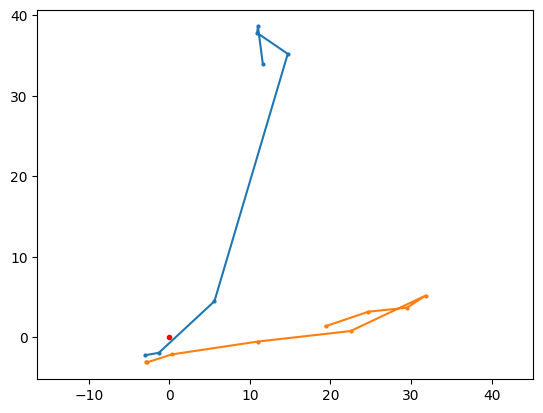

Spanish Oaks - Apr 18/bags/base_station/converted__SO_5.0_multi


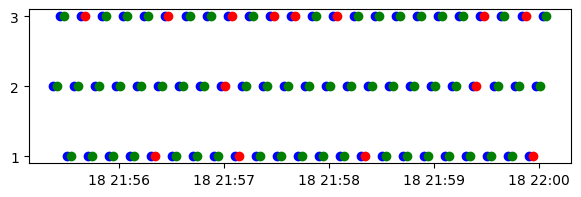

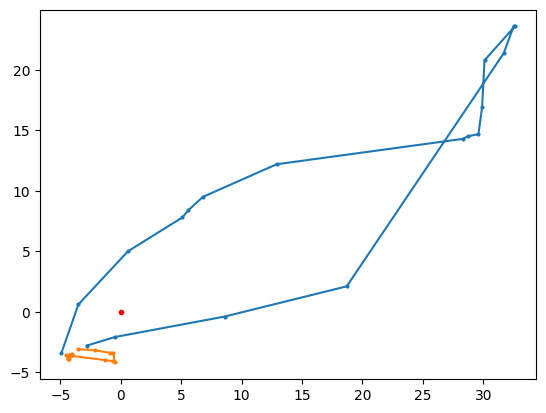

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_24_30


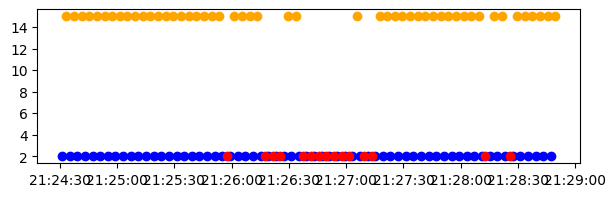

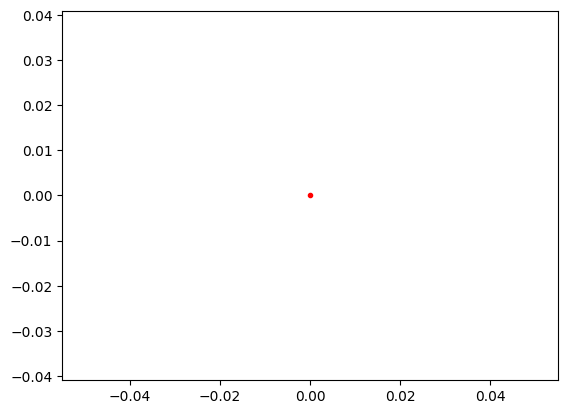

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-14_46_02


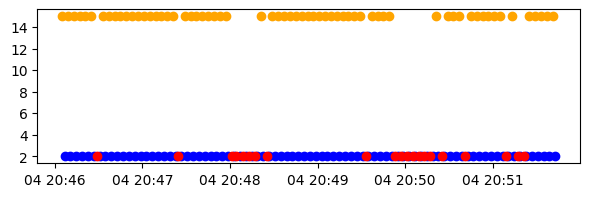

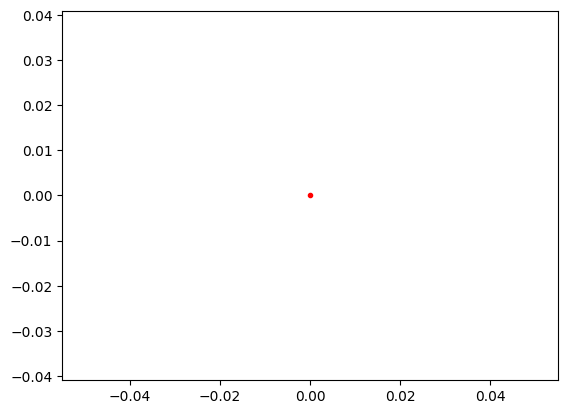

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_09_02


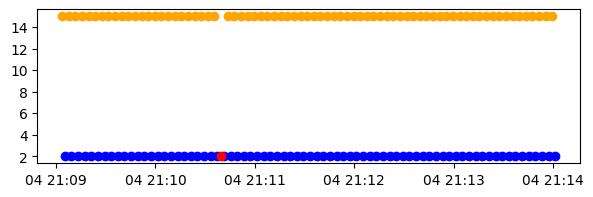

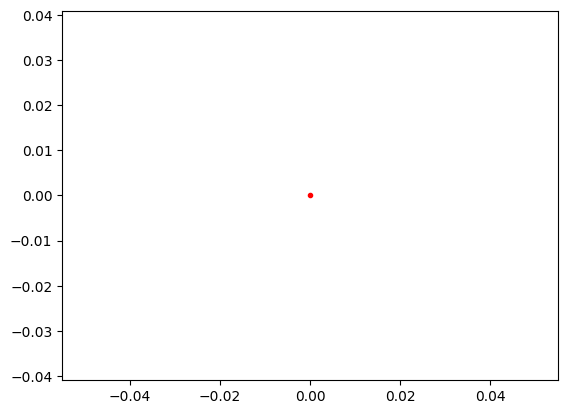

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_17_45


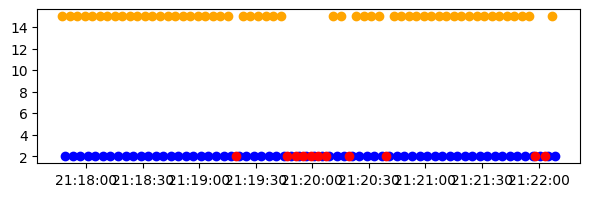

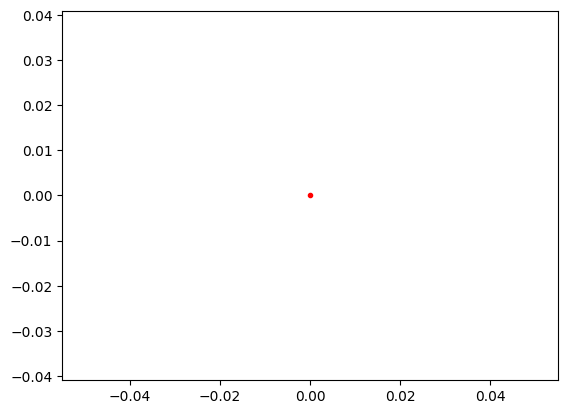

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-16_21_13


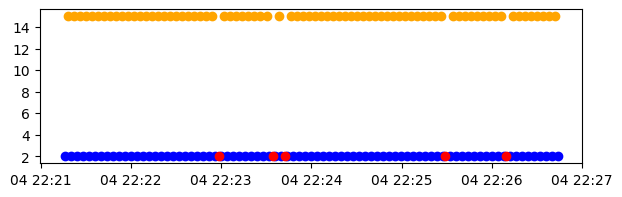

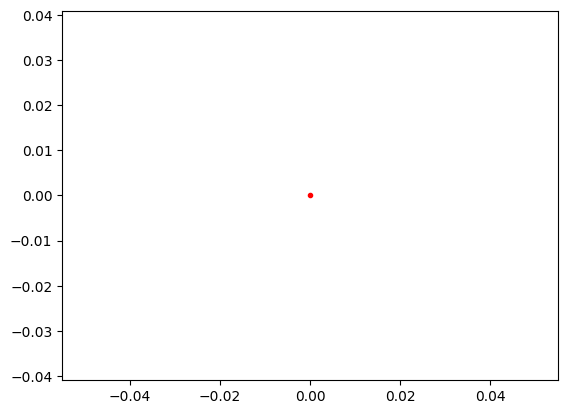

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_49_19


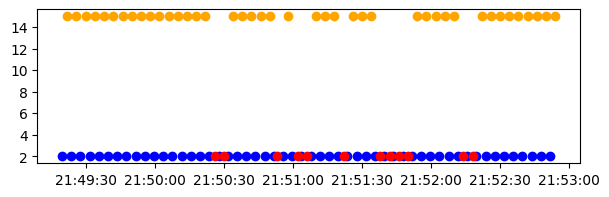

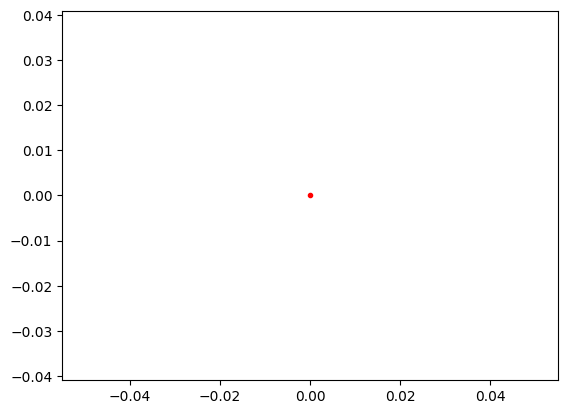

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_35_40


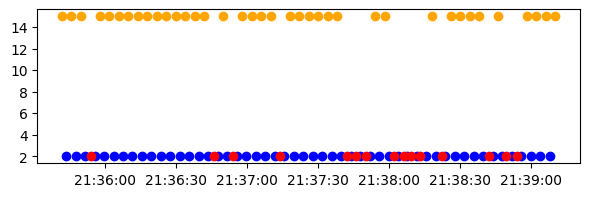

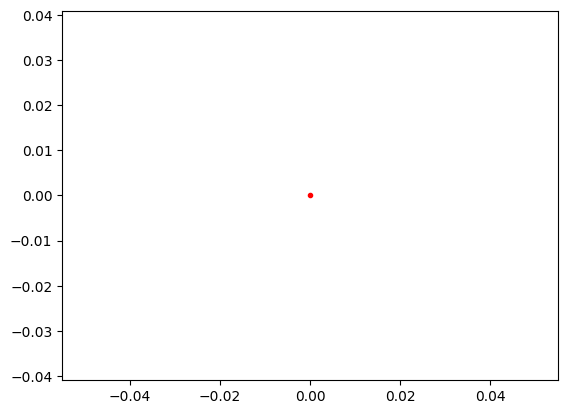

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_59_14


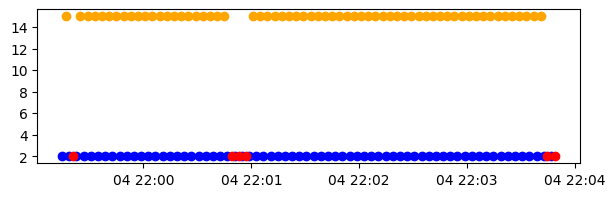

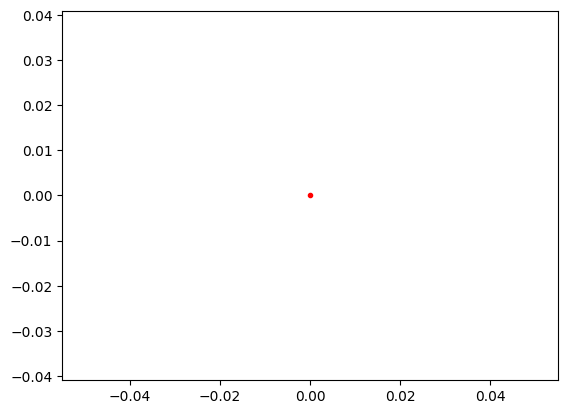

Spanish Oaks - April 4th/bags/base-station-bags/converted__rosbag2_2025_04_04-15_42_06


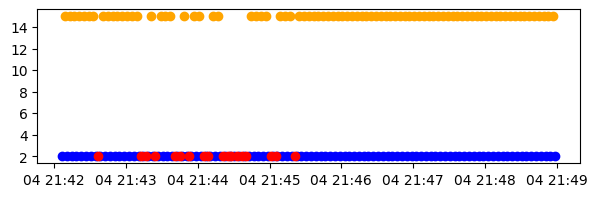

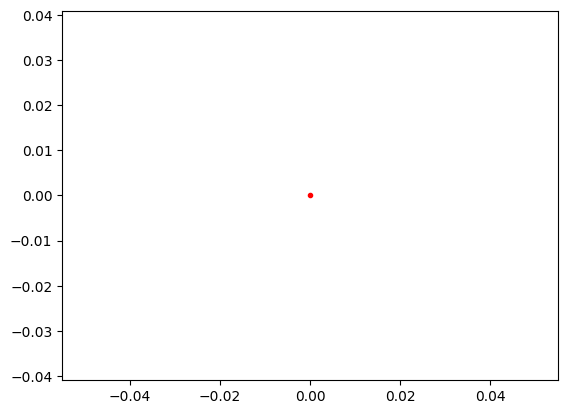

In [ ]:
for path, topics in dataframes.items():
    ax=None
    if '/modem_rec' in topics.keys():
        # Base station pings over time with responses (check time sync err)
        print(path)
        bst_rec = topics["/modem_rec"]
        if not (bst_rec["range_dist"]>0).any():
            continue
        if (bst_rec["target_id"])
        bst_cmd = topics["/modem_cmd_update"]
        bst_send = bst_cmd[bst_cmd["command_status_code"]==CST_E.CST_OK]
        bst_err = bst_cmd[bst_cmd["command_status_code"]!=CST_E.CST_OK]

        bst_rec_plt_err = bst_rec[bst_rec["position_flt_error"]]
        bst_rec_good = bst_rec[~bst_rec["position_flt_error"]]

        fig, ax = plt.subplots(figsize=(7, 2))
        ax.plot(bst_send["timestamp"], bst_send["target_id"], 'bo')
        ax.plot(bst_rec_good["timestamp"], bst_rec_good["src_id"], 'go')
        ax.plot(bst_rec_plt_err["timestamp"], bst_rec_plt_err["src_id"], 'o', color='orange')
        ax.plot(bst_err["timestamp"], bst_err["target_id"], 'ro')

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

        for bid in range(15):
            modem_from_bid = bst_rec[bst_rec['src_id']==bid]
            if len(modem_from_bid)>0:
                plt.plot(modem_from_bid['position_easting']/10,
                        modem_from_bid['position_northing']/10, 
                        "-o", markersize=2)
        plt.plot([0],[0],'ro',markersize=3)
        plt.axis('equal')
    plt.show()